In [194]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import fetch_openml
import pickle
from scipy.special import expit
from sklearn.model_selection import train_test_split

## Open MNIST data and create a subset with desired digits

<font color=red>Change the code below to select a different subset </font>

In [195]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = np.asarray([int(numeric_string) for numeric_string in y])

# Change 
class1Indices = (y==3)
class2Indices = (y==4)

x1 = X[class1Indices]
x2 = X[class2Indices]

Xtrain = np.concatenate((x1,x2),axis=0)
ytrain = np.concatenate((np.zeros(x1.shape[0]),np.ones(x2.shape[0])),axis=0)

# Saving the temporary variables for fast retrieval
with open('temp.pickle', 'wb') as handle:
    pickle.dump([Xtrain, ytrain], handle)


# Split the data to training, testing, and validation subsets

In [196]:
# loading the temporary variables for fast retrieval
with open('temp.pickle', 'rb') as handle:
    Xtrain, ytrain = pickle.load(handle)
    
# Split the data to training, testing, and validation subsets
    
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=1) # QUESTION: This should be 0.2?

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.14, random_state=1) # 0.25 x 0.8 = 0.2, # QUESTION: this should be 0.1?


Nsamples = X_train.shape[0]
Nfeatures = X_train.shape[1]


# Accuracy of a classifier

In [197]:
def testLinearClassifier(a,X,y):
    misclassifications = 0

    for i in range(0, len(X)):
        x_tilde = np.hstack((X[i], 1))
        y_estimate = np.matmul(a.T, x_tilde)

        if y_estimate <= 0 and y[i] == 1:
            misclassifications += 1
        elif y_estimate > 0 and y[i] == 0:
            misclassifications += 1
        
    print(f"Mis-classifications= {misclassifications} out of {len(X)} equivalent to {(misclassifications / len(X))*100} %")

    return misclassifications


## Define and test gaussianClassifierWithIdentityCovariance 

Mis-classifications= 194 out of 8406 equivalent to 2.3078753271472756 %
Mis-classifications= 27 out of 1369 equivalent to 1.9722425127830532 %
Mis-classifications= 86 out of 4190 equivalent to 2.052505966587112 %


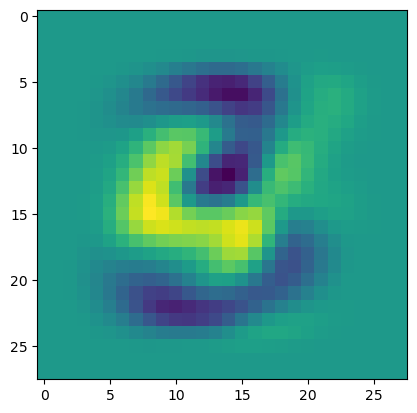

In [198]:
#------TRAINING CODE --------------

def gaussianClassifierWithIdentityCovariance(Xtrain,ytrain):
    class1_indices = (ytrain==0)
    class2_indices = (ytrain==1)
    xTrain1 = Xtrain[class1_indices]
    xTrain2 = Xtrain[class2_indices]

    #mean should be a 1 x 784 size matrix
    u1 = np.mean(xTrain1, axis = 0)
    u2 = np.mean(xTrain2, axis = 0)

    identity_cov = np.identity(len(u1))
    wT = np.matmul(np.transpose(u2-u1), np.linalg.pinv(identity_cov)) # REF: Decision HyperSurfaces (slide 28)
    wNot = -1* np.matmul(wT, (u1+u2)/2)

    a = np.transpose(np.hstack((wT, wNot))) # REF: Project phase 1 description
    
    return a


#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = gaussianClassifierWithIdentityCovariance(X_train,y_train)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)


## Define and test gaussianClassifierWithCommonCovariance 

Mis-classifications= 56 out of 8406 equivalent to 0.6661908160837497 %
Mis-classifications= 8 out of 1369 equivalent to 0.5843681519357196 %
Mis-classifications= 46 out of 4190 equivalent to 1.097852028639618 %


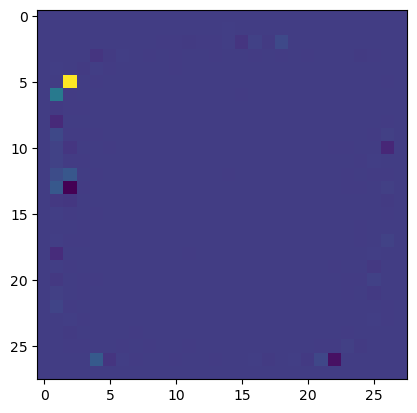

In [199]:
#------TRAINING CODE --------------

def gaussianClassifierWithCommonCovariance(Xtrain,ytrain):
    class1_indices = (ytrain==0)
    class2_indices = (ytrain==1)
    xTrain1 = Xtrain[class1_indices]
    xTrain2 = Xtrain[class2_indices]

    # Means
    u1 = np.mean(xTrain1, axis=0)
    u2 = np.mean(xTrain2, axis=0)

    # Creating the Shared COV
    class1_demeaned = xTrain1 - u1[None, :]
    class2_demeaned = xTrain2 - u2[None, :]
    pooled_features = np.row_stack([class1_demeaned,class2_demeaned])
    shared_cov = np.cov(np.transpose(pooled_features)) # Ref: Decision_Surfaces MA

    ''' Another alternative to pinv():
    for i in range(0, len(shared_cov)):
        if shared_cov[i][i] < 1:
            shared_cov[i][i] = 1
    '''

    # np.linalg.inv() returns error - use pinv() instead
    wT = np.matmul(np.transpose(u2-u1), np.linalg.pinv(shared_cov)) # REF: Decision HyperSurfaces (slide 28)
    wNot = -1* np.matmul(wT, (u1+u2)/2)

    a = np.transpose(np.hstack((wT, wNot))) # REF: Project phase 1 description

    return a
    
#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = gaussianClassifierWithCommonCovariance(X_train,y_train)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)


## Define and test logisticRegression 

You may choose the step size as 1e-4. You can try changing it.

Use the expit() function from scipy.special.expit to implement sigmoid without overflow errors 

Mis-classifications= 20 out of 8406 equivalent to 0.23792529145848204 %
Mis-classifications= 12 out of 1369 equivalent to 0.8765522279035792 %
Mis-classifications= 42 out of 4190 equivalent to 1.0023866348448687 %


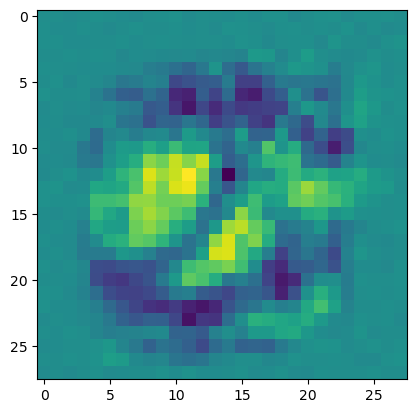

In [201]:
def logisticRegression(Xtrain,ytrain,iterations=100,step_size=1e-4,verbose=False):
    A = np.random.randn(len(Xtrain[0])+1, 1)
    Xtilde = np.vstack((Xtrain.T, np.repeat(1, len(Xtrain), axis=0)))

    for iter in range(iterations):
        s = expit(np.matmul(A.T, Xtilde))
        error = s-ytrain
        gradient = -np.matmul(Xtilde, error.T)
        A = A + step_size*gradient

    a = A
    
    return a
    
#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = logisticRegression(X_train,y_train,iterations=500,verbose=False)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)



Complete your code
Mis-classifications= 4908.0 out of  8897 equivalent to 55.1646622457008 %
Mis-classifications= 779.0 out of  1449 equivalent to 53.76121463077985 %
Mis-classifications= 2467.0 out of  4434 equivalent to 55.638249887235006 %


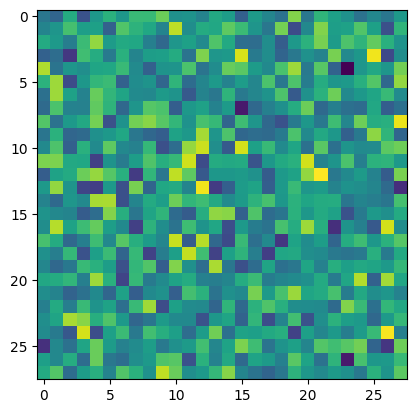

In [14]:
def logisticRegressionWithRegularization(Xtrain,ytrain,iterations=100,step_size=1e-4,lam=0,verbose=False):


    a = 0.01*np.random.randn(Nfeatures+1,1)
    print("Complete your code")
    
    return a
    #YOUR CODE HERE

    
#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = logisticRegressionWithRegularization(X_train,y_train,iterations=500,verbose=False,lam=1)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)


In [83]:
def optimizeHyperparameters(Xtrain,ytrain):
     
        # YOUR CODE HERE
        
    return lamopt


# REPORT TEST ERRORS OF THE BEST MODELS

YOUR CODE BELOW